# Random forest for HAMBI data 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
import joblib

seed = 98


## Import data

In [ ]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'

In [ ]:
data = pd.read_csv("/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv", sep="\t", index_col=0, header=0,low_memory=False)

In [ ]:
data.head()

In [ ]:
data['Domain to species'].value_counts(dropna=False)

In [ ]:
len(data['Domain to species'].value_counts(dropna=False))

In [158]:
len(data.value_counts(dropna=False))

1951

In [ ]:
# Target 'Domain to species' = 's'?
len(data['Domain to species'].value_counts(dropna=False))
len(data['s'].value_counts(dropna=False))

# Random forest classifier 
## All data

In [ ]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['s'].unique())
    print(f"before filtering number of classes {len(data['s'].value_counts())}")   
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"after filtering number of classes {len(data_filtered['s'].value_counts())}")
    classes_after = set(data_filtered['s'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    """Filter out the contigs that have less than n samples in the given column.
    
    Parameters:
    - data (pd.DataFrame): Data frame with the data.
    - column_name (str): Column name to filter out.
    - n (int): Minimum number of samples.
    """
    print(f"before filtering number of classes {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"after filtering number of classes {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model: RandomForestClassifier, title: str, output_dir: str, target: str):
    """Plot the confusion matrix for the given true and predicted values.
    
    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (pd.Series): Predicted labels.
    - model (RandomForestClassifier): Trained model.
    - title (str): Title of the plot.
    - output_dir (str): Path to the output directory where the plot will be saved.
    - target (str): Target colu<mn.
    """

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(50, 50))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True,
                annot_kws={"size": 50})
    plt.xticks(rotation=90, fontsize=40, fontstyle='italic'
               #horizontalalignment='left', verticalalignment='baseline'
              )
    plt.yticks(rotation=0, fontsize=40, fontstyle='italic')
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=80)
    plt.xlabel('Predicted Labels', fontsize=50)
    plt.ylabel('True Labels', fontsize=50)
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    title = title.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.savefig(os.path.join(output_dir, f'{title}.jpg'))
    plt.close()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, output_dir: str, target: str):
    """Plot the distribution of the train and test sets.
    
    Parameters:
    - y_train (pd.Series): True labels of the train set.
    - y_test (pd.Series): True labels of the test set.
    - output_dir (str): Path to the output directory.
    """
    print("Plotting the distribution")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    print("Number of samples in each species in the train set:")
    print(train_species_counts)
    print("\nNumber of samples in each species in the test set:")
    print(test_species_counts)
    num_classes = len(set(y_train.unique()).union(set(y_test.unique())))
    
    width = max(12, num_classes * 0.6)
    height = max(8, num_classes * 0.8)
    
    plt.figure(figsize=(width, height))
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)

    target = target.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.png'), bbox_inches='tight')

    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.jpg'))
    plt.show()

    plt.close()

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target:str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """

    plt.figure(figsize=(20, 10))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    plt.bar(range(top_n), importances[top_indices], align='center', color='skyblue')
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of {top_n} features with target {target}", fontsize=20)
    plt.tight_layout()
    output_name = f'{target.replace(" ", "_")}_feature_importance.png'
    plt.savefig(os.path.join(output_dir, output_name))
    plt.savefig(os.path.join(output_dir, output_name.replace('.png', '.jpg')))
    plt.close()

def train_test_model(df: pd.DataFrame, output_folder: str, target: str):
    """Train and test the random forest classifier.

    Parameters:
    - df (pd.DataFrame): Data frame with the data.
    - output_folder (str): Path to the output directory to save the results for the model plots
    - target (str): Target column.
    """
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X_DS = filtered_data.iloc[:, :492] 
    y_DS = filtered_data[target]

    X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_DS, y_DS, test_size=0.2, random_state=seed, stratify=y_DS)
    plot_train_test_distribution(y_train_DS, y_test_DS, output_folder, target)
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train_DS, y_train_DS)

    y_train_pred_DS = model.predict(X_train_DS)
    y_test_pred_DS = model.predict(X_test_DS)

    plot_confusion_matrix(y_train_DS, y_train_pred_DS, model, f'Train Set with target {target}', output_folder, target)
    plot_confusion_matrix(y_test_DS, y_test_pred_DS, model, f'Test Set with target {target}', output_folder, target)

    plot_feature_importance(model, X_DS, target, 30, output_folder)

    metrics = pd.DataFrame({
            'Accuracy Train': [accuracy_score(y_train_DS, y_train_pred_DS)],
            'Accuracy Test': [accuracy_score(y_test_DS, y_test_pred_DS)],
            'Precision': [precision_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'Recall': [recall_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'F1 Score': [f1_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)]
        })
    
    metrics.to_csv(os.path.join(output_folder, f'{target.replace(" ", "_")}_metrics.tsv'), sep='\t')
    print(f"Metrics for target {target}")
    print(metrics)

    if accuracy_score(y_test_DS, y_test_pred_DS) > 0.7:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
        model_file_path = os.path.join(output_folder, f'{target.replace(" ", "_")}_model.joblib')
        print(f"Saving the model to {model_file_path}")
        joblib.dump(model, model_file_path)
    else:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
    return y_test_DS, y_test_pred_DS
    

In [ ]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

y_test_DS, y_test_pred_DS = train_test_model(data, output_folder, 's')

In [ ]:
len(np.unique(y_test_pred_DS))

In [ ]:
train_test_model(data, output_folder, 'Domain to genus')
train_test_model(data, output_folder, 'g')

In [ ]:
train_test_model(data, output_folder, 'Domain to family')
train_test_model(data, output_folder, 'f')

In [ ]:
train_test_model(data, output_folder, 'Domain to order')
train_test_model(data, output_folder, 'o')

In [ ]:
train_test_model(data, output_folder, 'Domain to class')
train_test_model(data, output_folder, 'c')

In [ ]:
train_test_model(data, output_folder, 'Domain to phylum')
train_test_model(data, output_folder, 'p')

# Trying with the most important features
## All data

In [ ]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['Domain to species'].unique())
    print(f"Before filtering, number of classes: {len(data['Domain to species'].value_counts())}")    
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"After filtering, number of classes: {len(data_filtered['Domain to species'].value_counts())}")
    classes_after = set(data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    print(f"Before filtering, number of classes: {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"After filtering, number of classes: {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model, title: str, target: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat_70.png'), bbox_inches='tight')
    
    plt.show()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, target: str):
    print("Plotting the distribution of train and test sets")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.figure(figsize=(12, 8))
    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target: str, top_n: int = 30):
    """Plot the feature importance of the model with color-coded bars by methylation type.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    """
    methylation_colors = {
        'm6A': 'skyblue',
        'm4C': 'lightcoral',
        'modified_base': 'lightgreen',
        'other': 'gray'
    }

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]

    # Vertical bar plot
    plt.figure(figsize=(25, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), top_features, rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.tight_layout()
    plt.show()

    # Horizontal bar plot
    fig, ax = plt.subplots(figsize=(20, max(5, top_n // 3)))
    ax.barh(range(top_n), importances[top_indices], color=bar_colors)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features, fontsize=8)
    ax.set_ylim(-0.5, top_n - 0.5) 

    ax.set_xlim(0, max(importances[top_indices]) * 1.05)

    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    #plt.save
    plt.savefig(os.path.join(output_folder, f'{target}_features.png'))
    plt.show()

def train_test_model(df: pd.DataFrame, target: str, n:int):
    
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X = filtered_data.iloc[:, :492]
    y = filtered_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    plot_train_test_distribution(y_train, y_test, target)

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot_confusion_matrix(y_train, y_train_pred, model, 'Train Set', target)
    #plot_confusion_matrix(y_test, y_test_pred, model, 'Test Set', target)

    plot_feature_importance(model, X, target, top_n=n)

    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with all features")
    print(metrics)

    importances = model.feature_importances_
    top_n = n
    top_features_indices = np.argsort(importances)[::-1][:top_n]
    X_train_top = X_train.iloc[:, top_features_indices]
    X_test_top = X_test.iloc[:, top_features_indices]

    model_top = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model_top.fit(X_train_top, y_train)

    y_train_pred = model_top.predict(X_train_top)
    y_test_pred = model_top.predict(X_test_top)

    plot_confusion_matrix(y_train, y_train_pred, model_top, 'Train Set', target)
    plot_confusion_matrix(y_test, y_test_pred, model_top, 'Test Set', target)


    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with top {n} features")
    print(metrics)

    return y_test, y_test_pred

In [ ]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['Domain to species'].unique())
    print(f"Before filtering, number of classes: {len(data['Domain to species'].value_counts())}")    
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"After filtering, number of classes: {len(data_filtered['Domain to species'].value_counts())}")
    classes_after = set(data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    print(f"Before filtering, number of classes: {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"After filtering, number of classes: {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model, title: str, target: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat_70.png'), bbox_inches='tight')
    
    plt.show()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, target: str):
    print("Plotting the distribution of train and test sets")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.figure(figsize=(12, 8))
    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target: str, top_n: int = 30):
    """Plot the feature importance of the model with color-coded bars by methylation type.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    """
    methylation_colors = {
        'm6A': 'skyblue',
        'm4C': 'lightcoral',
        'modified_base': 'lightgreen',
        'other': 'gray'
    }

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]

    # Vertical bar plot
    plt.figure(figsize=(25, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), top_features, rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.tight_layout()
    plt.show()

    # Horizontal bar plot
    fig, ax = plt.subplots(figsize=(20, max(5, top_n // 3)))
    ax.barh(range(top_n), importances[top_indices], color=bar_colors)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features, fontsize=8)
    ax.set_ylim(-0.5, top_n - 0.5) 

    ax.set_xlim(0, max(importances[top_indices]) * 1.05)

    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    #plt.save
    plt.savefig(os.path.join(output_folder, f'{target}_features.png'))
    plt.show()

def train_test_model(df: pd.DataFrame, target: str, n:int):
    
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X = filtered_data.iloc[:, :492]
    y = filtered_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    plot_train_test_distribution(y_train, y_test, target)

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot_confusion_matrix(y_train, y_train_pred, model, 'Train Set', target)
    #plot_confusion_matrix(y_test, y_test_pred, model, 'Test Set', target)

    plot_feature_importance(model, X, target, top_n=n)

    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with all features")
    print(metrics)

    importances = model.feature_importances_
    top_n = n
    top_features_indices = np.argsort(importances)[::-1][:top_n]
    X_train_top = X_train.iloc[:, top_features_indices]
    X_test_top = X_test.iloc[:, top_features_indices]

    model_top = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model_top.fit(X_train_top, y_train)

    y_train_pred = model_top.predict(X_train_top)
    y_test_pred = model_top.predict(X_test_top)

    plot_confusion_matrix(y_train, y_train_pred, model_top, 'Train Set', target)
    plot_confusion_matrix(y_test, y_test_pred, model_top, 'Test Set', target)


    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with top {n} features")
    print(metrics)

    return y_test, y_test_pred

# Trying different number of features 
## All data

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 1)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 3)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 5)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 10)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 20)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 50)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 60)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 70)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 80)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 90)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 100)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 120)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 150)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 180)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 200)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 250)

*******************************************
# Create data without element 'plasmid'

# Random forest classifier 
## Chromosome data

In [153]:
chrom_data = data[data['element'].str.contains('chromo', case=False, na=True)]
chrom_data.head()

,-20_A_m4C,-19_A_m4C,-18_A_m4C,-17_A_m4C,-16_A_m4C,-15_A_m4C,-14_A_m4C,-13_A_m4C,-12_A_m4C,-11_A_m4C,...,s,element,str,All,Domain to species,Domain to genus,Domain to family,Domain to order,Domain to class,Domain to phylum
0,,,,,,,,,,,,,,,,,,,,,
bcAd1023T--bcAd1023T_ptg000028l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,Comamonas_testosteroni_C,chromosome,HAMBI_0403,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota
bcAd1023T--bcAd1023T_ptg000139l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bcAd1023T--bcAd1023T_ptg000005c,0.002806,-0.008088,-0.020686,0.001876,0.002186,-0.022589,-0.00434,-0.03184,-0.078417,0.034193,...,Sphingobacterium_spiritivorum,chromosome,HAMBI_1896,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...,Bacteria_Bacteroidota_Bacteroidia,Bacteria_Bacteroidota
bcAd1023T--bcAd1023T_ptg000084l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,Comamonas_testosteroni_C,chromosome,HAMBI_0403,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota
bcAd1023T--bcAd1023T_ptg000212l,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,...,Stenotrophomonas_maltophilia,chromosome,HAMBI_2659,Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...,Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...,Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...,Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...,Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...,Bacteria_Pseudomonadota_Gammaproteobacteria,Bacteria_Pseudomonadota


In [154]:
has_nan = chrom_data['All'].isna().any()
print(has_nan)

True


In [ ]:
chrom_data['Domain to species'].value_counts(dropna=False)

In [159]:
len(chrom_data['Domain to species'].value_counts(dropna=False))

16

In [160]:
len(chrom_data.value_counts(dropna=False))

1807

In [156]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(chrom_data['s'].unique())
    print(f"before filtering number of classes {len(chrom_data['s'].value_counts())}")    
    chrom_data_filtered = chrom_data.dropna(subset=['All'], axis=0)
    chrom_data_filtered = chrom_data_filtered[(chrom_data_filtered['All'] != '') & (chrom_data_filtered['All'] != 'Bacteria')]
    chrom_data_filtered = chrom_data_filtered[(chrom_data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"after filtering number of classes {len(chrom_data_filtered['s'].value_counts())}")
    classes_after = set(chrom_data_filtered['s'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return chrom_data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    """Filter out the contigs that have less than n samples in the given column.
    
    Parameters:
    - data (pd.DataFrame): Data frame with the data.
    - column_name (str): Column name to filter out.
    - n (int): Minimum number of samples.
    """
    print(f"before filtering number of classes {len(chrom_data[column_name].value_counts())}")
    counts = chrom_data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_chrom_data = chrom_data[chrom_data[column_name].isin(classes)]
    filtered_chrom_data = filtered_chrom_data.dropna(subset=[column_name], axis=0)
    print(f"after filtering number of classes {len(filtered_chrom_data[column_name].value_counts())}")

    return filtered_chrom_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model: RandomForestClassifier, title: str, output_dir: str, target: str):
    """Plot the confusion matrix for the given true and predicted values.
    
    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (pd.Series): Predicted labels.
    - model (RandomForestClassifier): Trained model.
    - title (str): Title of the plot.
    - output_dir (str): Path to the output directory where the plot will be saved.
    - target (str): Target column.
    """

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(50, 50))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True,
                annot_kws={"size": 50})
    plt.xticks(rotation=90, fontsize=40, fontstyle='italic'
               #horizontalalignment='left', verticalalignment='baseline'
              )
    plt.yticks(rotation=0, fontsize=40, fontstyle='italic')
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=80)
    plt.xlabel('Predicted Labels', fontsize=50)
    plt.ylabel('True Labels', fontsize=50)
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    title = title.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.savefig(os.path.join(output_dir, f'{title}.jpg'))
    plt.close()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, output_dir: str, target: str):
    """Plot the distribution of the train and test sets.
    
    Parameters:
    - y_train (pd.Series): True labels of the train set.
    - y_test (pd.Series): True labels of the test set.
    - output_dir (str): Path to the output directory.
    """
    print("Plotting the distribution")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    print("Number of samples in each species in the train set:")
    print(train_species_counts)
    print("\nNumber of samples in each species in the test set:")
    print(test_species_counts)
    num_classes = len(set(y_train.unique()).union(set(y_test.unique())))
    
    width = max(12, num_classes * 0.6)
    height = max(8, num_classes * 0.8)
    
    plt.figure(figsize=(width, height))
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90, fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)

    target = target.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.png'), bbox_inches='tight')

    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.jpg'))
    plt.show()

    plt.close()

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target:str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """

    plt.figure(figsize=(20, 10))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    plt.bar(range(top_n), importances[top_indices], align='center', color='skyblue')
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of {top_n} features with target {target}", fontsize=20)
    plt.tight_layout()
    output_name = f'{target.replace(" ", "_")}_feature_importance.png'
    plt.savefig(os.path.join(output_dir, output_name))
    plt.savefig(os.path.join(output_dir, output_name.replace('.png', '.jpg')))
    plt.close()

def train_test_model(df: pd.DataFrame, output_folder_chrom: str, target: str):
    """Train and test the random forest classifier.

    Parameters:
    - df (pd.DataFrame): Data frame with the data.
    - output_folder_chrom (str): Path to the output directory to save the results for the model plots
    - target (str): Target column.
    """
    print(f"Training the model with target: {target}")
    filtered_chrom_data = clean_data(df)
    filtered_chrom_data = filter_out_n(filtered_chrom_data, target, 10)
    
    X_DS = filtered_chrom_data.iloc[:, :492] 
    y_DS = filtered_chrom_data[target]

    X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_DS, y_DS, test_size=0.2, random_state=seed, stratify=y_DS)
    plot_train_test_distribution(y_train_DS, y_test_DS, output_folder_chrom, target)
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train_DS, y_train_DS)

    y_train_pred_DS = model.predict(X_train_DS)
    y_test_pred_DS = model.predict(X_test_DS)

    plot_confusion_matrix(y_train_DS, y_train_pred_DS, model, f'Train Set with target {target}', output_folder_chrom, target)
    plot_confusion_matrix(y_test_DS, y_test_pred_DS, model, f'Test Set with target {target}', output_folder_chrom, target)

    plot_feature_importance(model, X_DS, target, 30, output_folder_chrom)

    metrics = pd.DataFrame({
            'Accuracy Train': [accuracy_score(y_train_DS, y_train_pred_DS)],
            'Accuracy Test': [accuracy_score(y_test_DS, y_test_pred_DS)],
            'Precision': [precision_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'Recall': [recall_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'F1 Score': [f1_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)]
        })
    
    metrics.to_csv(os.path.join(output_folder_chrom, f'{target.replace(" ", "_")}_metrics.tsv'), sep='\t')
    print(f"Metrics for target {target}")
    print(metrics)

    if accuracy_score(y_test_DS, y_test_pred_DS) > 0.7:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
        model_file_path = os.path.join(output_folder_chrom, f'{target.replace(" ", "_")}_model.joblib')
        print(f"Saving the model to {model_file_path}")
        joblib.dump(model, model_file_path)
    else:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
    return y_test_DS, y_test_pred_DS
    

Training the model with target: s
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 15
after filtering number of classes 12
Plotting the distribution
Number of samples in each species in the train set:
s
Citrobacter_B_koseri            165
Bordetella_avium                123
Comamonas_testosteroni_C        116
Cupriavidus_oxalaticus           93
Pseudomonas_E_putida             89
Microvirga_lotononidis           88
Morganella_morganii              69
Pseudomonas_E_chlororaphis       65
Paracoccus_denitrificans         36
Aeromonas_caviae                 29
Stenotrophomonas_maltophilia     26
Sphingobium_yanoikuyae           14
Name: count, dtype: int64

Number of samples in each species in the test set:
s
Citrobacter_B_koseri            41
Bordetella_avium                31
Comamonas_testosteroni_C        29
Cupriavidus_oxalaticus          23
Pseudomonas_E_putida            22
Microvirga_lotononidis    

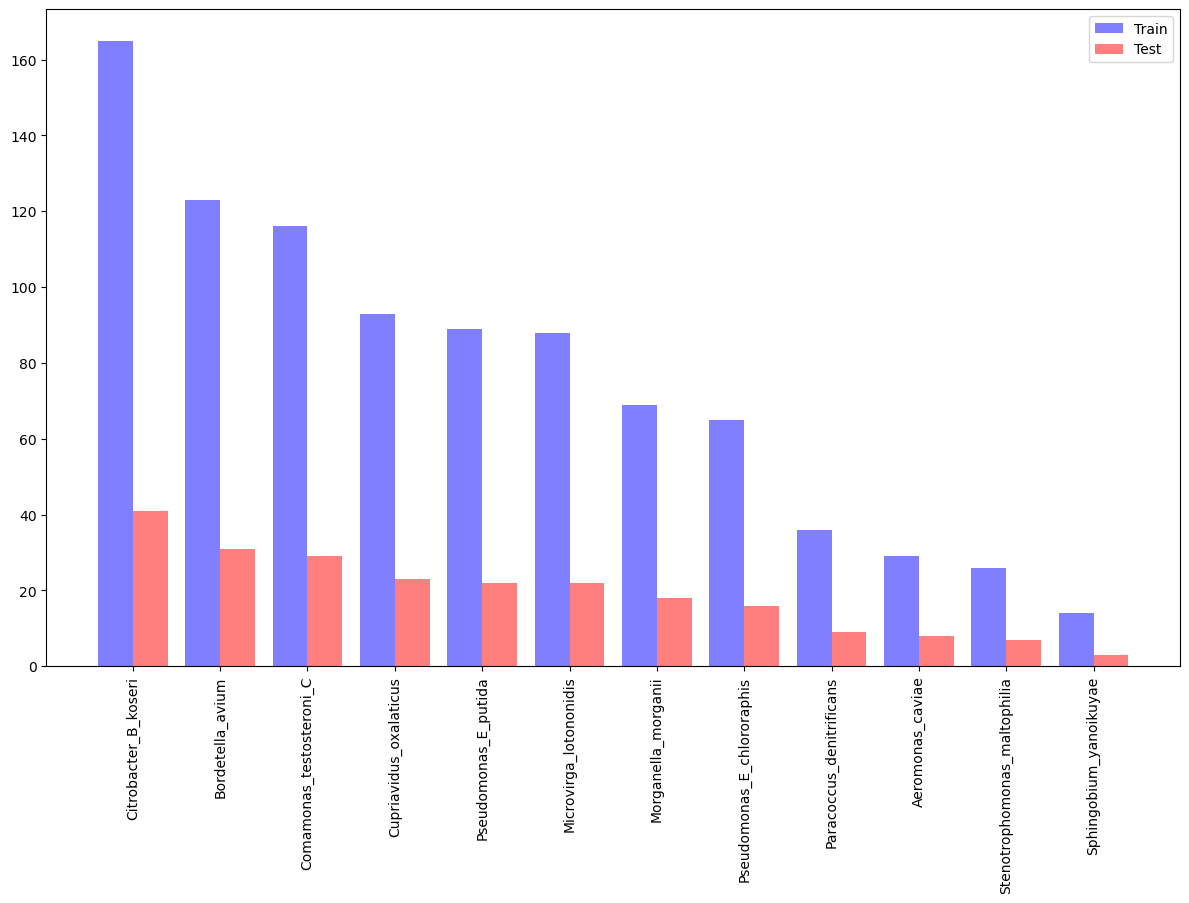

Metrics for target s
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0         0.75356       0.567686   0.695316  0.567686  0.598401
Model trained with accuracy: 0.5676855895196506


In [157]:
output_folder_chrom = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI_chrom'
if not os.path.exists(output_folder_chrom):
    os.makedirs(output_folder_chrom)

y_test_DS, y_test_pred_DS = train_test_model(chrom_data, output_folder_chrom, 's')

In [ ]:
len(np.unique(y_test_pred_DS))

In [ ]:
train_test_model(chrom_data, output_folder_chrom, 'g')

In [ ]:
train_test_model(chrom_data, output_folder_chrom, 'f')

In [ ]:
train_test_model(chrom_data, output_folder_chrom, 'o')

In [ ]:
train_test_model(chrom_data, output_folder_chrom, 'c')

In [ ]:
train_test_model(chrom_data, output_folder_chrom, 'p')

# Trying with the most important features
## Chromosome data

In [ ]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(chrom_data['Domain to species'].unique())
    print(f"Before filtering, number of classes: {len(chrom_data['Domain to species'].value_counts())}")    
    chrom_data_filtered = chrom_data.dropna(subset=['All'], axis=0)
    chrom_data_filtered = chrom_data_filtered[(chrom_data_filtered['All'] != '') & (chrom_data_filtered['All'] != 'Bacteria')]
    chrom_data_filtered = chrom_data_filtered[(chrom_data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"After filtering, number of classes: {len(chrom_data_filtered['Domain to species'].value_counts())}")
    classes_after = set(chrom_data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return chrom_data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    print(f"Before filtering, number of classes: {len(chrom_data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_chrom_data = chrom_data[chrom_data[column_name].isin(classes)]
    filtered_chrom_data = filtered_chrom_data.dropna(subset=[column_name], axis=0)
    print(f"After filtering, number of classes: {len(filtered_chrom_data[column_name].value_counts())}")

    return filtered_chrom_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model, title: str, target: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    plt.savefig(os.path.join(output_folder_chrom, f'{target}_confusion_mat_70.png'), bbox_inches='tight')
    
    plt.show()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, target: str):
    print("Plotting the distribution of train and test sets")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.figure(figsize=(12, 8))
    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target: str, top_n: int = 30):
    """Plot the feature importance of the model with color-coded bars by methylation type.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    """
    methylation_colors = {
        'm6A': 'skyblue',
        'm4C': 'lightcoral',
        'modified_base': 'lightgreen',
        'other': 'gray'
    }

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]

    # Vertical bar plot
    plt.figure(figsize=(25, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), top_features, rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.tight_layout()
    plt.show()

    # Horizontal bar plot
    fig, ax = plt.subplots(figsize=(20, max(5, top_n // 3)))
    ax.barh(range(top_n), importances[top_indices], color=bar_colors)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features, fontsize=8)
    ax.set_ylim(-0.5, top_n - 0.5) 

    ax.set_xlim(0, max(importances[top_indices]) * 1.05)

    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    #plt.save
    plt.savefig(os.path.join(output_folder_chrom, f'{target}_features.png'))
    plt.show()

def train_test_model(df: pd.DataFrame, target: str, n:int):
    
    print(f"Training the model with target: {target}")
    filtered_chrom_data = clean_data(df)
    filtered_chrom_data = filter_out_n(filtered_chrom_data, target, 10)
    
    X = filtered_chrom_data.iloc[:, :492]
    y = filtered_chrom_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    plot_train_test_distribution(y_train, y_test, target)

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot_confusion_matrix(y_train, y_train_pred, model, 'Train Set', target)
    #plot_confusion_matrix(y_test, y_test_pred, model, 'Test Set', target)

    plot_feature_importance(model, X, target, top_n=n)

    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with all features")
    print(metrics)

    importances = model.feature_importances_
    top_n = n
    top_features_indices = np.argsort(importances)[::-1][:top_n]
    X_train_top = X_train.iloc[:, top_features_indices]
    X_test_top = X_test.iloc[:, top_features_indices]

    model_top = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model_top.fit(X_train_top, y_train)

    y_train_pred = model_top.predict(X_train_top)
    y_test_pred = model_top.predict(X_test_top)

    plot_confusion_matrix(y_train, y_train_pred, model_top, 'Train Set', target)
    plot_confusion_matrix(y_test, y_test_pred, model_top, 'Test Set', target)


    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with top {n} features")
    print(metrics)

    return y_test, y_test_pred

# Trying different number of features 
## Chromosome data

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 5)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 10)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 20)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 50)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 70)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 120)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 200)

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(chrom_data, 'Domain to species', 250)

# Count data included:

In [ ]:
count_row1 = data.shape[0]
count_row2 = len(data.value_counts())
count_row3 = chrom_data.shape[0]
count_row4 = len(chrom_data.value_counts())
print(f"All data: {count_row1}")
print(f"All data, without NA: {count_row2}")
print(f"Chromosomes data: {count_row3}")
print(f"Chromosomes, without NA: {count_row4}")

# Continue with most important features (70) and all data

In [ ]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['Domain to species'].unique())
    print(f"Before filtering, number of classes: {len(data['Domain to species'].value_counts())}")    
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"After filtering, number of classes: {len(data_filtered['Domain to species'].value_counts())}")
    classes_after = set(data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    print(f"Before filtering, number of classes: {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"After filtering, number of classes: {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model, title: str, target: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat_70.png'), bbox_inches='tight')
    
    plt.show()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, target: str):
    print("Plotting the distribution of train and test sets")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.figure(figsize=(12, 8))
    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target: str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model and save the top features to a file.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """
    
    # Check if output directory is provided and exists, if not, create it
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Calculate feature importances and sort
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
    
    # Get the top_n features
    top_indices = indices[:top_n]
    top_features = pd.DataFrame({
        'Feature': X.columns[top_indices],
        'Importance': importances[top_indices]
    })
    
    # Save the top features DataFrame to a CSV file
    if output_dir:
        top_features_path = os.path.join(output_dir, f'{target.replace(" ", "_")}_top_features.csv')
        top_features.to_csv(top_features_path, index=False)
        print(f"Top features saved as {top_features_path}")
    
    # Plot the feature importances
    plt.figure(figsize=(20, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color='skyblue')
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of {top_n} Features with Target {target}", fontsize=20)
    plt.tight_layout()

    # Save plot
    if output_dir:
        output_name = f'{target.replace(" ", "_")}_feature_importance.png'
        output_path = os.path.join(output_dir, output_name)
        plt.savefig(output_path)
        print(f"Feature importance plot saved as {output_path}")
    
    # Close the plot to free memory
    plt.close()

def train_test_model(df: pd.DataFrame, target: str, n:int):
    
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X = filtered_data.iloc[:, :492]
    y = filtered_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    plot_train_test_distribution(y_train, y_test, target)

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot_confusion_matrix(y_train, y_train_pred, model, 'Train Set', target)
    #plot_confusion_matrix(y_test, y_test_pred, model, 'Test Set', target)

    plot_feature_importance(model, X, target, top_n=n, output_dir='RF_HAMBI')

    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with all features")
    print(metrics)

    importances = model.feature_importances_
    top_n = n
    top_features_indices = np.argsort(importances)[::-1][:top_n]
    X_train_top = X_train.iloc[:, top_features_indices]
    X_test_top = X_test.iloc[:, top_features_indices]

    model_top = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model_top.fit(X_train_top, y_train)

    y_train_pred = model_top.predict(X_train_top)
    y_test_pred = model_top.predict(X_test_top)

    plot_confusion_matrix(y_train, y_train_pred, model_top, 'Train Set', target)
    plot_confusion_matrix(y_test, y_test_pred, model_top, 'Test Set', target)


    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with top {n} features")
    print(metrics)

    return y_test, y_test_pred

In [ ]:
output_dir = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'

In [ ]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 70)